In [1]:

import os
import sys
sys.path.append("../")
import glob
from hphc.helpers import ProjUNETPrediction, Integer_to_border, MeasureArea, DistWater, AfterUNET
from tifffile import imread, imwrite
from skimage import measure
from skimage import morphology
from skimage.measure import label
import napari
import numpy as np
%gui qt

In [2]:
Masterdir = '/media/sancere/Newton_Volume_1/DalmiroAnalysis/NewCode/Avg/'
Resultsdir = '/media/sancere/Newton_Volume_1/DalmiroAnalysis/NewCode/Results/'
BinaryName = 'BinaryWater'
HairSegName = 'Water'
VeinImageName = 'Vein'
MaskName = 'Mask'
MarkerName = 'Markers'
CsvName = 'Area_Stats'
max_label_area = 400

First we redo the watershed segmentation by adding/removing hair cells

In [ ]:
Raw_path = os.path.join(Masterdir, '*tif')
filesRaw = glob.glob(Raw_path)

for fname in filesRaw:
    
    viewer = napari.Viewer() 
    image = imread(fname)
    Name = os.path.basename(os.path.splitext(fname)[0])
    print(Name)
    MarkerImage = imread(Resultsdir + Name + MarkerName + '.tif')
    MarkerImage = MarkerImage.astype('uint16')
    MaskImage = imread(Resultsdir + Name + MaskName + '.tif')
    IntegerImage = imread(Resultsdir + Name + HairSegName + '.tif')
    IntegerImage = IntegerImage.astype('uint16')
    Veinimage = imread(Resultsdir + Name + VeinImageName + '.tif')
    
    NewMarkerImage = np.zeros(MarkerImage.shape)
    waterproperties = measure.regionprops(MarkerImage)
    Coordinates = [prop.centroid for prop in waterproperties]
    Coordinates = sorted(Coordinates , key=lambda k: [k[0], k[1]])
    viewer.add_image(image, name = Name)
    viewer.add_points(data = Coordinates, name= 'Markers', face_color= [0]*4, edge_color = "red", ndim = 2)
    
                         
    viewer.show(block=True)
            
    NewCoordinates = viewer.layers['Markers'].data
    coordinates_int = np.round(NewCoordinates).astype(int)
    NewMarkerImage[tuple(coordinates_int.T)] = 1 + np.arange(len(NewCoordinates))

    markers = morphology.dilation(NewMarkerImage, morphology.disk(2))  
     
    #Redo Watershed                     
    WaterImage, BinaryImage = AfterUNET(IntegerImage > 0, NewCoordinates, MaskImage, Veinimage) 
    print(Resultsdir  +   Name + MarkerName)                     
    imwrite((Resultsdir  +   Name + MarkerName + '.tif' ) , markers) 
    imwrite((Resultsdir  +   Name + HairSegName + '.tif' ) , WaterImage) 
    imwrite((Resultsdir  +   Name + BinaryName + '.tif' ) , BinaryImage)                     

Correct for the segmentation Masks and obtian size statistics

Mean Area 357.24673388864534 Max Area 13532 Max Area Label 8083    8213
Name: Label_ID, dtype: int64


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/sancere/anaconda3/envs/naparienv/lib/python3.9/site-packages/zmq/eventloop/zmqstream.py", line 431, in _run_callback
    callback(*args, **kwargs)
  File "/home/sancere/anaconda3/envs/naparienv/lib/python3.9/site-packages/jupyter_client/threaded.py", line 121, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/sancere/anaconda3/envs/naparienv/lib/python3.9/asyncio/base_events.py", line 618, in run_until_complete
    self._check_running()
  File "/home/sancere/anaconda3/envs/naparienv/lib/python3.9/asyncio/base_events.py", line 580, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/sancere/anaconda3/envs/naparienv/lib/python3.9/site-packages

Mean Area 357.24673388864534 Max Area 13532 Max Area Label 8083    8213
Name: Label_ID, dtype: int64


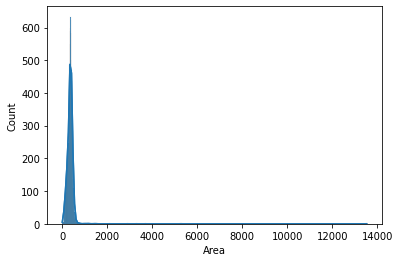

In [3]:
Raw_path = os.path.join(Masterdir, '*tif')
filesRaw = glob.glob(Raw_path)
filesRaw.sort

Results_path = os.path.join(Resultsdir, '*tif')
filesResults = glob.glob(Results_path)
filesResults.sort
for fname in filesRaw:
    viewer = napari.Viewer() 
    image = imread(fname)
    Name = os.path.basename(os.path.splitext(fname)[0])
    BinaryImage = imread(Resultsdir + Name + BinaryName + '.tif')
    IntegerImage = imread(Resultsdir + Name + HairSegName + '.tif')
   
    MaskImage = imread(Resultsdir + Name + MaskName + '.tif')
    viewer = napari.Viewer()
    viewer.add_image(image)
    viewer.add_labels(IntegerImage, name = 'Integer_Labels')

    viewer.add_labels(BinaryImage, name = 'Binary_Segmentation')
    viewer.add_labels(MaskImage, name = 'Wing_Mask')
    
    #Block viewer
        
    viewer.show(block=True)
            
    ModifiedArraySeg = viewer.layers['Integer_Labels'].data 
    ModifiedArraySeg = ModifiedArraySeg.astype('uint16')
    LabelMaskImage = ModifiedArraySeg > 0
    Compartment = label(LabelMaskImage)
    ModifiedArrayMask = viewer.layers['Wing_Mask'].data 
    ModifiedArrayMask = ModifiedArrayMask.astype('uint8')
    
    BinaryImage = Integer_to_border(ModifiedArraySeg)
    
    imwrite((Resultsdir  +   Name + HairSegName + '.tif' ) , ModifiedArraySeg) 
    imwrite((Resultsdir  +   Name + BinaryName + '.tif' ) , BinaryImage)
    imwrite((Resultsdir  +   Name + MaskName + '.tif' ) , MaskImage)
    MeasureArea(ModifiedArraySeg,LabelMaskImage, Resultsdir, Name)
    